In [35]:
import pandas as pd

# Load the dataset
df = pd.read_csv('traffic.csv')  # Update path if needed
print(df.head())
print(df.columns)

# Clean column names (if any whitespaces)
df.columns = df.columns.str.strip()

# Convert DateTime column to datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# Check for nulls and info
print(df.info())
print(df.describe())


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.8 MB
None
                            DateTime      Junction      Vehicles            ID
count                          48120  48120.000000  48120.000000  4.812000e+04

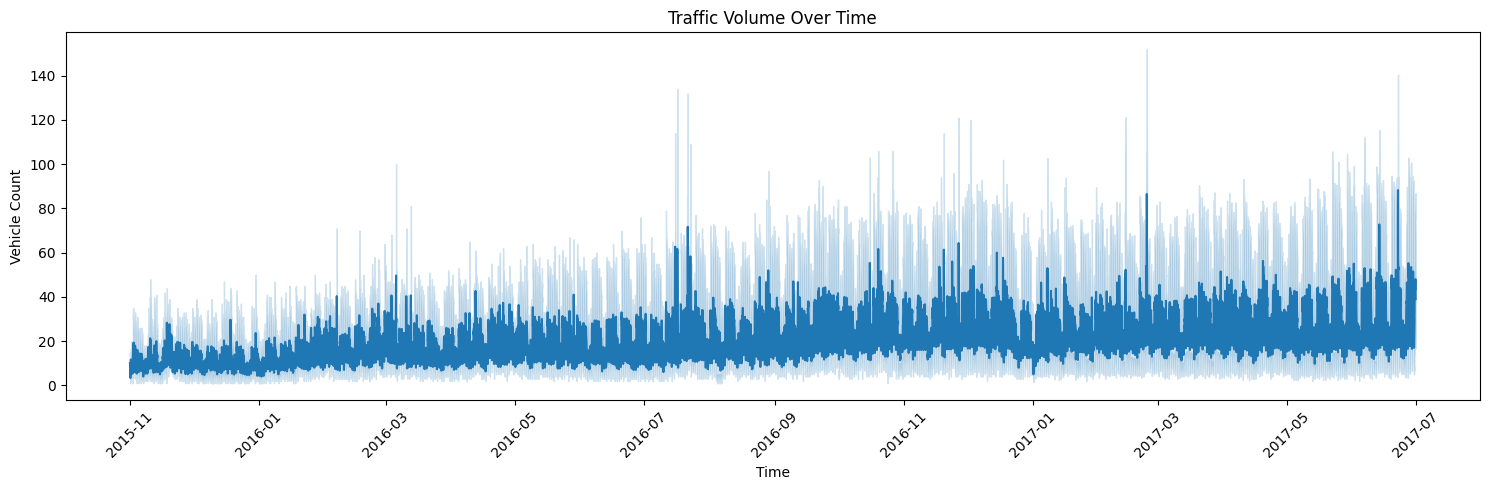

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.lineplot(x=df['DateTime'], y=df['Vehicles'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Vehicle Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-37-f158d521a9d1>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df.set_index('DateTime').resample('H').sum()['Vehicles']


MSE: 169838.90314122746


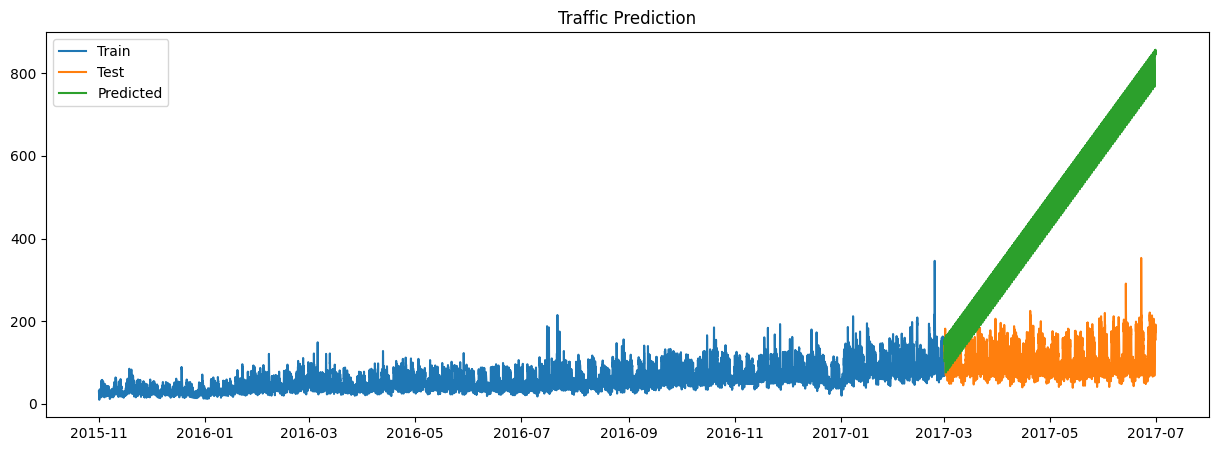

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Resample for smoother time series (hourly)
ts = df.set_index('DateTime').resample('H').sum()['Vehicles']

# Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Fit model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 24))
results = model.fit()

# Predict
preds = results.predict(start=test.index[0], end=test.index[-1])
mse = mean_squared_error(test, preds)
print("MSE:", mse)

# Plot
plt.figure(figsize=(15,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(preds.index, preds, label='Predicted')
plt.legend()
plt.title("Traffic Prediction")
plt.show()


In [39]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.6 MB/s eta 0:00:00


In [40]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

# Build a graph using Junctions
junctions = df['Junction'].unique()
junction_map = {j: i for i, j in enumerate(junctions)}

# Assume edges between all pairs for simplicity
edges = []
for j1 in junctions:
    for j2 in junctions:
        if j1 != j2:
            edges.append([junction_map[j1], junction_map[j2]])

edge_index = torch.tensor(edges).t().contiguous()

# Node features: average traffic volume at each junction
node_features = []
for j in junctions:
    avg_traffic = df[df['Junction'] == j]['Vehicles'].mean()
    node_features.append([avg_traffic])

x = torch.tensor(node_features, dtype=torch.float)

# Labels: 1 if average traffic > threshold (congested)
y = torch.tensor([1 if v[0] > df['Vehicles'].mean() else 0 for v in node_features], dtype=torch.long)

# Create Data object
data = Data(x=x, edge_index=edge_index, y=y)


In [41]:
# Define GCN Model
class TrafficGCN(torch.nn.Module):
    def __init__(self):
        super(TrafficGCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = TrafficGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Train GNN
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 17.125324249267578
Epoch 10, Loss: 9.072806358337402
Epoch 20, Loss: 3.7121548652648926
Epoch 30, Loss: 0.876805305480957
Epoch 40, Loss: 0.5927587151527405
Epoch 50, Loss: 0.6436883211135864
Epoch 60, Loss: 0.5963834524154663
Epoch 70, Loss: 0.5649142265319824
Epoch 80, Loss: 0.563082218170166
Epoch 90, Loss: 0.5638800859451294
